# 모두의 딥러닝 개정 3판
## 20장 전이 학습을 통해 딥러닝의 성능 극대화하기
- 머신 러닝과 달리 딥러닝은 스스로 중요한 속성을 뽑아 학습하기 때문에 비교적 많은 양의 데이터 필요
- 딥러닝의 데이터양이 충분하지 않을 때 활용할 수 있는 방법들 배울 예정
- 전이 학습(transfer learning): 수만 장에 달하는 기존의 이미지에서 학습한 정보를 가져와 내 프로젝트에 활용하는 것
### 1 소규모 데이터셋으로 만드는 강력한 학습 모델
- 지도학습(supervised learning) : 정답을 알고 학습 폐암수술 환자의 생존율 예측, 피마 인디언의 당뇨병 예측, CNN을 이용한 MNIST 분류, CNN을 이용한 치매환자 MRI 뇌 사진 분류
- 비지도학습(unsupervised learning) : 정답 없이 시작하여 정답 예측 GAN이, 오토인코더

- 이미지 같은경우 충분한 학습데이터를 모으는것이 쉽지않음
- 이럴때 쓸수있는 방법을 두가지를 알아볼것
- 각 data폴더안에 train, test폴더에
- normal 정상뇌사진 ad 치매뇌사진이
- train 80장씩 test 60장씩 있음

In [1]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"

In [2]:
BATCH_SIZE = 5

- ImageDataGenerator() : keras에서 제공하는 데이터가 아닌 내 데이터 읽어오기 주어진 데이터 변형한 이미지를 만들어 학습셋에 포함시켜줌 이는 학습셋에만 적용하는 것이 좋음. 테스트셋에 실제 정보를 유지시키는 것이 과적합 위험 방지 가능
- flow_from_directory() : 폴더에 저장된 데이터를 불러오기

In [3]:
# 학습셋의 변형 설정
# 데이터 특성에 맞게 항목을 골라써야함
# 특징을 미묘하게 바꿔서
# 이미지 데이터의 수를 확장할 때 효과적으로 사용할 수 있다
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  )   

In [4]:
train_generator = train_datagen.flow_from_directory(
       './data/train',   # 학습셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=BATCH_SIZE,
       class_mode='binary') # 이진분류 (정상0 / 치매1)

Found 160 images belonging to 2 classes.


In [5]:
# 테스트셋 이미지 생성 옵션 부여 및 생성
test_datagen = ImageDataGenerator(rescale=1./255)  

test_generator = test_datagen.flow_from_directory(
       './data/test',   # 테스트셋이 있는 폴더의 위치입니다.
       target_size=(150, 150),
       batch_size=BATCH_SIZE,
       class_mode='binary')

Found 120 images belonging to 2 classes.


In [6]:
# CNN 모델을 만들어 적용
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 activation (Activation)     (None, 148, 148, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 72, 72, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                    

In [7]:
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.0002),
              metrics=['accuracy'])

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [9]:
history = model.fit(
    train_generator, epochs=100,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

Epoch 1/100
32/32 [==============================] - 9s 242ms/step - loss: 0.7001 - accuracy: 0.4875 - val_loss: 0.6892 - val_accuracy: 0.5000
Epoch 2/100
32/32 [==============================] - 6s 191ms/step - loss: 0.6896 - accuracy: 0.5312 - val_loss: 0.6843 - val_accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 7s 217ms/step - loss: 0.6784 - accuracy: 0.5875 - val_loss: 0.6758 - val_accuracy: 0.5000
Epoch 4/100
32/32 [==============================] - 6s 191ms/step - loss: 0.6710 - accuracy: 0.5625 - val_loss: 0.6663 - val_accuracy: 0.5083
Epoch 5/100
32/32 [==============================] - 4s 136ms/step - loss: 0.6682 - accuracy: 0.5500 - val_loss: 0.6648 - val_accuracy: 0.5000
Epoch 6/100
32/32 [==============================] - 5s 152ms/step - loss: 0.6477 - accuracy: 0.5562 - val_loss: 0.6043 - val_accuracy: 0.8250
Epoch 7/100
32/32 [==============================] - 6s 187ms/step - loss: 0.6236 - accuracy: 0.6687 - val_loss: 0.5838 - val_accuracy: 0.7667

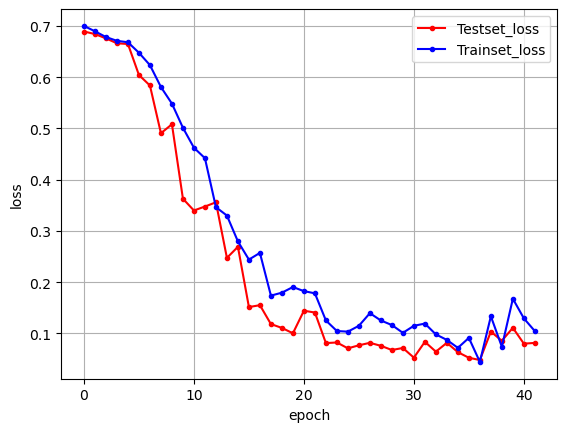

In [10]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()